In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
cmap = 'viridis'

from PIL import Image
color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
marker_list = ['o', 's', 'x', '^']
from inference import *

In [2]:
import pandas as pd
import re

## load and print data labels
filename_label = "./data/IN15/numorsumarytablenew.txt"
with open(filename_label, 'r') as f:
    labels = f.read().splitlines()

# Split the first line as header, the rest as data
header = [col for col in labels[0].split('\t') if col != 'x/y']
# Remove the empty column (the third column, index 2)
data = [ [entry for entry in row.split('\t') if entry != ''] for row in labels[1:] ]

df_labels = pd.DataFrame(data, columns=header)
print(header)
# print(df_labels[df_labels['numor'].astype(str).str.startswith('3')]['numor'])
data_25C = df_labels[df_labels['SampleName'].str.startswith('Dendrimer') & df_labels['numor'].astype(str).str.startswith('3')]
data_10C = df_labels[df_labels['SampleName'].str.startswith('lt_Dendrimer') & df_labels['numor'].astype(str).str.startswith('3')]
data_40C = df_labels[df_labels['SampleName'].str.startswith('ht_Dendrimer') & df_labels['numor'].astype(str).str.startswith('3')]
data_25C.loc[:, 'SampleName'] = data_25C['SampleName'].str.replace(r'^Dendrimer$', 'Dendrimer_25', regex=True)

# Extract temperature, measurement duration, and wavelength from data_25C

def extract_duration(sample_name):
    match = re.search(r'_(\d+)$', sample_name)
    return int(match.group(1)) if match else None

summary = []
for df, label in zip([data_25C, data_10C, data_40C], ['25C', '10C', '40C']):
    temps = df['TempSa'].unique()
    durations = df['SampleName'].apply(extract_duration).unique()
    wavelengths = df['Lambda'].unique()
    angles = df['Angle'].unique()
    summary.append({
        'Label': label,
        'Temperatures': temps,
        'Durations': durations,
        'Wavelengths': wavelengths,
        'Angles': angles
    })

for s in summary:
    print(f"{s['Label']}:")
    print(f"  Temperatures: {s['Temperatures']}")
    print(f"  Durations: {s['Durations']}")
    print(f"  Wavelengths: {s['Wavelengths']}")
    print(f"  Angles: {s['Angles']}\n")


['SampleName', 'TuneWave', 'numor', 'Average', 'averErr', 'Pol', 'PolErr', 'Echo_khi', 'phmap_stddev', 'phmap_khi', 'MonRate', 'TempSa', 'TempSaErr', 'TempRg', 'TempRgErr', 'Selector', 'Lambda', 'Angle']
25C:
  Temperatures: ['24.99995' '25' '25.00005' '25.000099' '25.000248' '25.000198'
 '24.999901' '24.999851' '24.999802']
  Durations: [25  5 10 50]
  Wavelengths: ['12' '10' '8' '6']
  Angles: ['3.49' '5.51' '7.01' '11.49']

10C:
  Temperatures: ['10.00005' '12.600346' '9.999703' '10.000099' '10.002921' '10.000545'
 '10.001683' '9.9984158' '10.000644' '10.001782' '10.000495' '10.001436'
 '9.9996535' '9.999802' '10.000198' '10.000149']
  Durations: [25  5 10 50]
  Wavelengths: ['10' '12' '6' '8']
  Angles: ['5.51' '3.49' '11.49' '7.01']

40C:
  Temperatures: ['40.000247' '39.996535' '39.999852' '40' '39.999951' '39.999208'
 '39.999753' '39.999406' '40.000049' '40.000198' '39.999752' '40.000099']
  Durations: [ 5 10 25 50]
  Wavelengths: ['10' '12' '6' '8']
  Angles: ['5.51' '3.49' '11

In [3]:
duration_list = np.unique([extract_duration(name) for name in data_25C['SampleName']])
conf_list, conf_indices = np.unique(data_25C['Lambda'], return_index=True)
# Sort angle_list according to conf_indices
angle_list_sorted = data_25C['Angle'].iloc[conf_indices].values
print("Wavelength for each configurations:", conf_list)
print("Angles for each configurations:", angle_list_sorted)
# Calculate Q for each configuration using Lambda and Angle
# Q = (4 * pi / lambda) * sin(theta / 2)
# Lambda in Angstrom, Angle in degrees
def calc_Q(lambda_A, angle_deg):
    theta_rad = np.deg2rad(angle_deg)
    return (4 * np.pi / lambda_A) * np.sin(theta_rad / 2)
Qm_list = []
for lam, ang in zip(conf_list.astype(float), angle_list_sorted.astype(float)):
    Q = calc_Q(lam, ang)
    Qm_list.append(Q)
Qm_list = np.array(Qm_list)
print("Q values for each configuration:", np.round(Qm_list, 4))

rebin_list = [3, 6, 9]

Wavelength for each configurations: ['10' '12' '6' '8']
Angles for each configurations: ['5.51' '3.49' '11.49' '7.01']
Q values for each configuration: [0.0604 0.0319 0.2097 0.096 ]


## 25C

In [62]:
data = data_40C.copy()
path = "./data/IN15/T40/"
rebin = rebin_list[2]

/tmp/ipykernel_3485024/3649060473.py:64: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(Qt_grid[0]).reshape([-1,1])
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:124: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


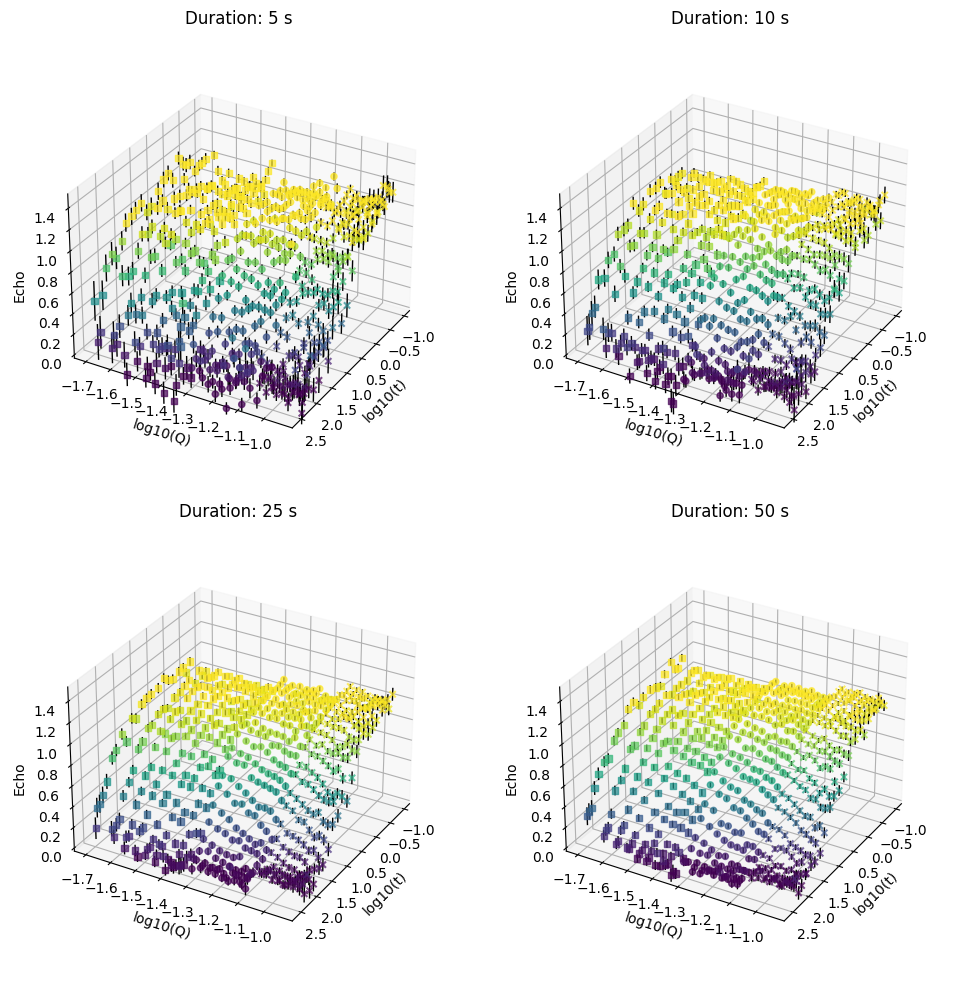

In [63]:
fig = plt.figure(figsize=(10, 10))
axs = []

sqt_list = []
sqt_err_list = []
for i, duration in enumerate(duration_list):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    axs.append(ax)
    Q_list = []
    echo_list = []
    echo_err_list = []
    t_list = []
    Qt_grid_list = []
    Q_flattened_list = []
    t_flattened_list = []
    echo_flattened_list = []
    echo_err_flattened_list = []
    for i_conf, conf in enumerate(conf_list[[0, 1, 3]]):  # Only use the first four configurations
        # Find the row in data_25C matching duration and Lambda (conf)
        row = data[(data['SampleName'].str.endswith(f'_{duration}')) & (data['Lambda'] == str(conf))]
        numor = row.iloc[0]['numor']
        # print(f"Processing numor: {numor}, conf: {conf}, duration: {duration}")
        filename_e = path+f"sl{rebin}/MD_e_{numor}.txt"
        filename_AP = path+f"sl{rebin}/MD_AP_{numor}.txt"

        # Load the data from filename_AP and extract the Q values and other columns
        data_AP = np.loadtxt(filename_AP, skiprows=2)
        Q = data_AP[:, 0]
        average = data_AP[:, 1]
        averErr = data_AP[:, 2]
        pol = data_AP[:, 3]
        polErr = data_AP[:, 4]

        Q_list.append(Q)
        
        # load the data from filename_e and extract the echo values
        data_e = np.loadtxt(filename_e, skiprows=2)
        t = data_e[:, 0]
        # Extract the echo columns corresponding to each Q
        echo_cols = np.array([i*2+1 for i in range(len(Q))])
        echo_values = data_e[:, echo_cols]
        echo_err = data_e[:, echo_cols+1]
        echo_flattened = echo_values.flatten()
        echo_err_flattened = echo_err.flatten()

        echo_list.append(echo_values)
        echo_err_list.append(echo_err)
        t_list.append(t)
        
        Qt_grid = np.meshgrid(t, Q, indexing='ij')
        Qt_grid_list.append(Qt_grid)
        Q_flattened = Qt_grid[1].flatten()
        t_flattened = Qt_grid[0].flatten()
        
        Q_flattened_list.append(Q_flattened)
        t_flattened_list.append(t_flattened)
        echo_flattened_list.append(echo_flattened)
        echo_err_flattened_list.append(echo_err_flattened)
        
        # Scatter plot with error bars
        multiplier = 1.0
        # if conf == 3:
        #     multiplier = 0.5
        x = np.log10(Qt_grid[0]).reshape([-1,1])
        y = np.log10(Qt_grid[1]).reshape([-1,1])
        z = echo_values.reshape([-1,1])*multiplier
        zerr = echo_err.reshape([-1,1])*multiplier
        ax.scatter(x, y, z, c=z, cmap=cmap, alpha=0.7, vmax=1, vmin=0, marker=marker_list[i_conf])
        # ax.scatter(np.log10(Qt_grid[0]), np.log10(Qt_grid[1]), echo_values*multiplier, marker=marker_list[i_conf])
        
        # Add vertical error bars
        for xi, yi, zi, ezi in zip(x.ravel(), y.ravel(), z.ravel(), zerr.ravel()):
            ax.plot([xi, xi], [yi, yi], [zi - ezi, zi + ezi], color='k', alpha=1, linewidth=1)


        ax.view_init(elev=30, azim=30)
        ax.set_zlim(0, 1.5)
        ax.set_xlabel('log10(t)')
        ax.set_ylabel('log10(Q)')
        ax.set_zlabel('Echo', rotation=90)
        ax.set_box_aspect(None, zoom=0.85)
        ax.set_title(f'Duration: {duration} s')
        
    # Concatenate echo_flattened_list for this duration and append to sqt_list
    sqt_list.append(np.concatenate(echo_flattened_list))
    sqt_err_list.append(np.concatenate(echo_err_flattened_list))
    # Concatenate Q_flattened_list and t_flattened_list for this duration
    Q_flattened = np.concatenate(Q_flattened_list)
    t_flattened = np.concatenate(t_flattened_list)

plt.tight_layout(pad=1.0)

In [64]:
sqt_list[0].shape

(621,)

L: 900, M: 621, N: 5


/tmp/ipykernel_3485024/1437090451.py:28: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_exp, c='k', alpha=0.7, vmax=1, vmin=0, marker='o', label='Observed')
/tmp/ipykernel_3485024/1437090451.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_exp, c='k', alpha=0.7, vmax=1, vmin=0, marker='o', label='Observed')


L: 900, M: 621, N: 5
L: 900, M: 621, N: 5
L: 900, M: 621, N: 5


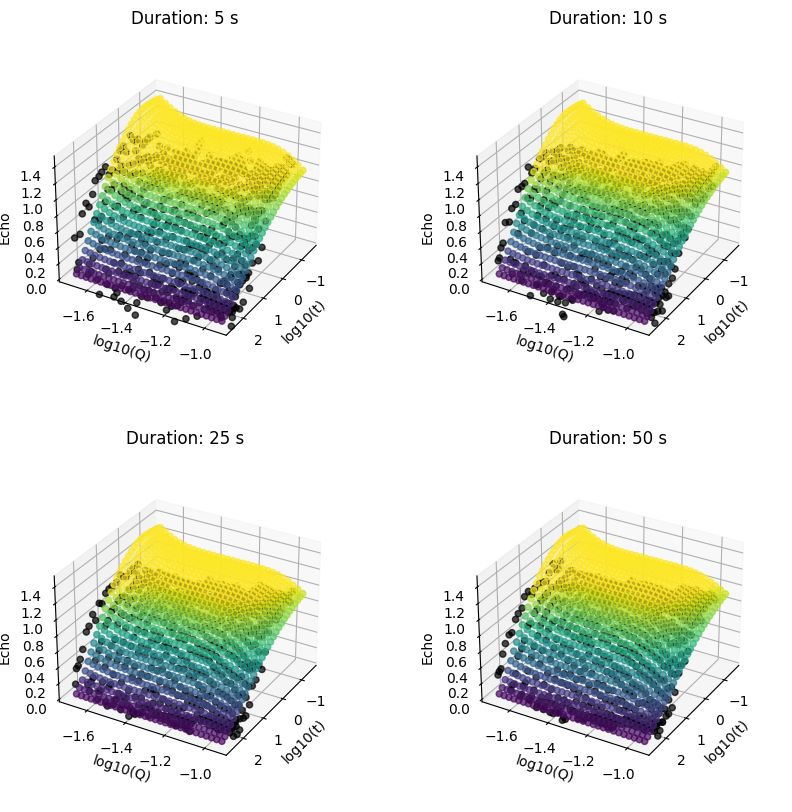

In [65]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(10, 10))
for i, duration in enumerate(duration_list):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    axs.append(ax)
    sqt_exp = sqt_list[i]
    delta_sqt_exp = sqt_err_list[i]
    Q_obs = Q_flattened
    t_obs = t_flattened
    Q_eval_grid, t_eval_grid = np.meshgrid(np.logspace(np.log10(Q_obs.min()), np.log10(Q_obs.max()), 30), np.logspace(-1.5, 2.5, 30))
    Q_eval = Q_eval_grid.flatten()
    t_eval = t_eval_grid.flatten()

    lambda_ = 0.25
    mu_ = lambda_

    N_Prony = 5
    # list_tau_i = np.exp(np.linspace(-4,2,N_Prony))
    list_tau_i = 10**(np.linspace(-2,2,N_Prony))
    tau = np.array(list_tau_i)
    bg_mode = False

    A_GPR, K_GPR, sqt_GPR = bayesian_inference(
        sqt_exp, delta_sqt_exp, np.log(Q_obs), t_obs, np.log(Q_eval), t_eval, tau, mu_, lambda_, bg_mode=bg_mode
    )
        
    ax.scatter(np.log10(t_eval), np.log10(Q_eval), sqt_GPR, c=sqt_GPR, alpha=0.7, vmax=1, vmin=0)
    ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_exp, c='k', alpha=0.7, vmax=1, vmin=0, marker='o', label='Observed')

    ax.view_init(elev=30, azim=30)
    ax.set_zlim(0, 1.5)
    ax.set_xlabel('log10(t)')
    ax.set_ylabel('log10(Q)')
    ax.set_zlabel('Echo', rotation=90)
    ax.set_box_aspect(None, zoom=0.85)
    ax.set_title(f'Duration: {duration} s')

In [66]:
len(echo_flattened_list)

3